#### Import Modules

In [22]:
import pandas as pd
import numpy as np
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize

data = pd.read_csv("training_data.csv")

#### What are the unique conditions?

In [2]:
data['condition'].unique()

array(['atrial_fib', 'chronic_kidney', 'pulmonary', 'depression',
       'diabetes', 'ischemia', 'asthma', 'hyperlip', 'hypertension',
       'arthritis', 'psychotic', 'stroke'], dtype=object)

#### How many conditions are there?

In [3]:
len(data['condition'].unique())

12

#### How many years of data do we have?

In [4]:
data['year'].unique()

array([2017, 2016, 2015], dtype=int64)

#### Create dataset

In [5]:
#potentially create region?
#create 12 variables for type of condition
binaries = pd.get_dummies(data['condition'])
newdata = pd.merge(data, binaries, left_index=True, right_index=True)

In [6]:
newdata.columns

Index(['state', 'condition', 'year', 'prev_less_65', 'prev_age_65_74',
       'prev_age_75_84', 'prev_above_84', 'prev_male', 'prev_female',
       'prev_white', 'prev_black', 'prev_hispanic', 'prev_other',
       'current_cost', 'last_year_cost', 'arthritis', 'asthma', 'atrial_fib',
       'chronic_kidney', 'depression', 'diabetes', 'hyperlip', 'hypertension',
       'ischemia', 'psychotic', 'pulmonary', 'stroke'],
      dtype='object')

In [7]:
finaldata = newdata[['prev_less_65', 'prev_age_65_74',
       'prev_age_75_84', 'prev_above_84', 'prev_male', 'prev_female',
       'prev_white', 'prev_black', 'prev_hispanic', 'prev_other',
       'current_cost', 'last_year_cost', 'arthritis', 'asthma', 'atrial_fib',
       'chronic_kidney', 'depression', 'diabetes', 'hyperlip', 'hypertension',
       'ischemia', 'psychotic', 'pulmonary', 'stroke']]

In [8]:
x_data = finaldata[['prev_less_65', 'prev_age_65_74',
       'prev_age_75_84', 'prev_above_84', 'prev_male', 'prev_female',
       'prev_white', 'prev_black', 'prev_hispanic', 'prev_other', 'last_year_cost',
       'arthritis', 'asthma', 'atrial_fib','chronic_kidney', 'depression',
        'diabetes', 'hyperlip', 'hypertension',
       'ischemia', 'psychotic', 'pulmonary', 'stroke']]
y_data = data.loc[:,"current_cost"]

#### Create test and training datasets

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size = .3, random_state = 100)

# Linear Regression

In [10]:
regr = LinearRegression()
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### R-squared

In [11]:
regr.score(x_train,y_train)

0.9413720615939674

In [12]:
regpredicttrain = regr.predict(x_train)

In [13]:
regpredicttrain

array([11616.11281858, 48538.5898686 , 38216.57795904, ...,
       25799.19870479, 33602.8774708 , 28779.27399255])

#### Residual Plots

In [14]:
residuals = (y_train - regpredicttrain)

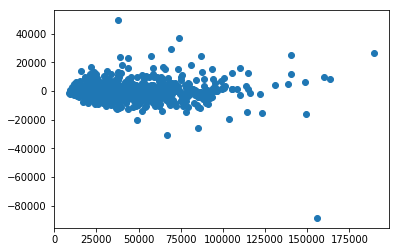

In [21]:
plt.scatter(regpredicttrain,residuals)

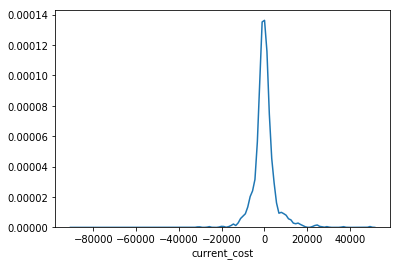

In [24]:
sns.distplot(residuals,hist = False,kde = True)

In [34]:
residuals[residuals<-80000]

1296   -88431.770042
Name: current_cost, dtype: float64

In [35]:
residuals[residuals>40000]

353    49379.112407
Name: current_cost, dtype: float64

In [36]:
regpredicttest = regr.predict(x_test)

#### MAE on Test Set

In [40]:
(regpredicttest-y_test).abs().mean()

3554.201483191758

#### RMSE on Test Set

In [48]:
np.sqrt(((regpredicttest-y_test)**2).sum()/len(regpredicttest))

6222.1508107630525

#### Create Prediction Dataset for Visualization Project

In [51]:
newdata2 = pd.read_csv("aggregations/aggregations/df_state_2017.csv")

In [74]:
dataofinterest = newdata2[['nppes_provider_state', 'beneficiary_age_less_65_total',
       'beneficiary_age_65_74_total', 'beneficiary_age_75_84_total',
       'beneficiary_age_greater_84_total', 'beneficiary_male_total',
       'beneficiary_female_total','beneficiary_race_white_total',
       'beneficiary_race_black_total','beneficiary_race_hispanic_total',
       'beneficiary_race_other_total']]

In [76]:
x_train.columns

Index(['prev_less_65', 'prev_age_65_74', 'prev_age_75_84', 'prev_above_84',
       'prev_male', 'prev_female', 'prev_white', 'prev_black', 'prev_hispanic',
       'prev_other', 'last_year_cost', 'arthritis', 'asthma', 'atrial_fib',
       'chronic_kidney', 'depression', 'diabetes', 'hyperlip', 'hypertension',
       'ischemia', 'psychotic', 'pulmonary', 'stroke'],
      dtype='object')

In [78]:
dataofinterest.rename(columns={'nppes_provider_state':'state', 'beneficiary_age_less_65_total':'prev_less_65',
       'beneficiary_age_65_74_total':'prev_age_65_74', 'beneficiary_age_75_84_total':'prev_age_75_84',
       'beneficiary_age_greater_84_total':'prev_above_84', 'beneficiary_male_total':'prev_male',
       'beneficiary_female_total':'prev_female','beneficiary_race_white_total':'prev_white',
       'beneficiary_race_black_total':'prev_black','beneficiary_race_hispanic_total':'prev_hispanic',
       'beneficiary_race_other_total':'prev_other'},inplace = True)

c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [80]:
dataofinterest.columns

Index(['state', 'prev_less_65', 'prev_age_65_74', 'prev_age_75_84',
       'prev_above_84', 'prev_male', 'prev_female', 'prev_white', 'prev_black',
       'prev_hispanic', 'prev_other'],
      dtype='object')

In [68]:
twosev_data = newdata[newdata['year']==2017]

In [69]:
twosev_data.drop(columns=['condition', 'year', 'prev_less_65', 'prev_age_65_74',
       'prev_age_75_84', 'prev_above_84', 'prev_male', 'prev_female',
       'prev_white', 'prev_black', 'prev_hispanic', 'prev_other','last_year_cost'],inplace = True)

c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
twosev_data.columns

Index(['state', 'current_cost', 'arthritis', 'asthma', 'atrial_fib',
       'chronic_kidney', 'depression', 'diabetes', 'hyperlip', 'hypertension',
       'ischemia', 'psychotic', 'pulmonary', 'stroke'],
      dtype='object')

In [71]:
twosev_data.rename(columns={"current_cost": "last_year_cost"},inplace = True)


c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [73]:
twosev_data.columns

Index(['state', 'last_year_cost', 'arthritis', 'asthma', 'atrial_fib',
       'chronic_kidney', 'depression', 'diabetes', 'hyperlip', 'hypertension',
       'ischemia', 'psychotic', 'pulmonary', 'stroke'],
      dtype='object')

In [87]:
twosev_data.columns

Index(['state', 'last_year_cost', 'arthritis', 'asthma', 'atrial_fib',
       'chronic_kidney', 'depression', 'diabetes', 'hyperlip', 'hypertension',
       'ischemia', 'psychotic', 'pulmonary', 'stroke'],
      dtype='object')

In [88]:
dataofinterest.columns

Index(['state', 'prev_less_65', 'prev_age_65_74', 'prev_age_75_84',
       'prev_above_84', 'prev_male', 'prev_female', 'prev_white', 'prev_black',
       'prev_hispanic', 'prev_other'],
      dtype='object')

In [94]:
predtwoeightdataprep = pd.merge(dataofinterest, twosev_data, how='inner', left_on='state', right_on='state')

In [96]:
predtwoeightdata = predtwoeightdataprep[['prev_less_65', 'prev_age_65_74', 'prev_age_75_84',
       'prev_above_84', 'prev_male', 'prev_female', 'prev_white', 'prev_black',
       'prev_hispanic', 'prev_other', 'last_year_cost', 'arthritis', 'asthma',
       'atrial_fib', 'chronic_kidney', 'depression', 'diabetes', 'hyperlip',
       'hypertension', 'ischemia', 'psychotic', 'pulmonary', 'stroke']]

# Predictions

In [98]:
regr.predict(predtwoeightdata)

array([ 78333.05396645,  53736.26586595,  45627.57754788,  29107.75646395,
        39309.95120654, 208493.13022184,  46202.20540142,  28362.59695432,
        41834.14996482,  32677.9824572 ,  24060.24242792,  31841.68890694,
        63667.10248915,  32869.66988525, 119518.07542884,  20928.90764912,
        28131.99225026,  61487.66157151,  33535.24408411,  20573.39012324,
        26837.20695267,  23254.3825529 ,  15251.98235882,  24036.65583272,
        35739.90252491,  20297.70207746,  88675.15153279,  21994.36564826,
        63175.1478485 ,  47937.99231361,  38025.13259057,  42491.97684788,
        42449.12073005,  37118.39045977,  42316.97783501,  57797.38817762,
        34614.38835037, 122267.02129488,  26684.25388904,  27539.32060833,
        71849.52608615,  78760.10852034,  64818.69482798,  70589.11320588,
        64555.27600696,  63496.30652333,  68288.32348032, 100125.39044087,
        58960.02913339, 174755.44461813,  63950.69733652,  79470.48172213,
       135358.29605997,  